Команда дейтинг-приложения разработала новый алгоритм для поиска наиболее подходящих анкет.  
Для проверки работы алгоритма был проведен АБ-тест, данные которого лежат в файле dating_data.  

Задача: оценить, правда ли, что новый алгоритм улучшил качество сервиса. 

In [1]:
import pandas as pd
import scipy.stats as ss

import seaborn as sns

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")
# импортируем библиотеки

In [3]:
df = pd.read_csv('C:/data_analyst/GitHub/dating_app/data/dating_data.csv')
# считываем данные в переменную df

In [4]:
df # выгрузка логов взаимодействия пользователей друг с другом

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1
...,...,...,...,...
14509,476,631,0,0
14510,455,770,1,0
14511,260,6,1,1
14512,885,812,1,1


Колонка **group**:  
**0** - пользователи в этой группе пользовались приложением со **старым алгоритмом** для поиска анкет  
**1** - пользователи в этой группе пользовались приложением с **новым алгоритмом** для поиска анкет  

Колонка **is_match**:  
**0** - мэтч **не случился**  
**1** - мэтч **случился**

Мы имеем 1000 уникальных пользователей.  
Пары не дублируются, т.е. у строчки: user_id_1 - 79, user_id_2 - 91 нет дубля user_id_1 - 91, user_id_2 - 79.  
Т.о. у пользователей количество мэтчей будет считаться не только по первой колонке, но и по второй, т.к. нет разницы в какой колонке он находится. Необходимо это учесть при последующем построении метрик. 

Проверим выше изложенное следующим образом. Убедимся в том, что у нас нет пользователя с одинаковым id отнесённым к разным группам AB-теста в разных колонках.

In [5]:
user_id_1_count_match = df.groupby(['user_id_1', 'group'], as_index=False).agg({'is_match':'sum'})
# создадим колонку, в которой покажем сколько метчей было у определённого id, находясь в колонке user_id_1,
# и к какой группе в АВ-тесте он относился
user_id_1_count_match.head(5)

,user_id_1,group,is_match
0,1,1,11
1,2,1,7
2,3,1,5
3,4,0,2
4,5,1,13


In [6]:
user_id_2_count_match = df.groupby(['user_id_2', 'group'], as_index=False).agg({'is_match':'sum'})
# создадим колонку, в которой покажем сколько метчей было у определённого id, находясь в колонке user_id_2,
# и к какой группе в АВ-тесте он относился
user_id_2_count_match.head(5)

,user_id_2,group,is_match
0,1,1,5
1,2,1,9
2,3,1,3
3,4,0,1
4,5,1,5


In [7]:
pd.DataFrame(user_id_1_count_match.group != user_id_2_count_match.group).sum()
# вывод ниже показывает в скольких количествах случаев группа для AB-теста (0 или 1) ,
# которой принадлежит id, из первой колонки не совпала с группой для AB-теста,
# которой принадлежит id, из второй колонки

group    0
dtype: int64

При предварительном исследовании данных мы выяснили что у нас всего 1000 уникальных пользователй в колонках user_id_1 и user_id_2

In [8]:
pd.crosstab(df.is_match, df.group) # строим таблицу сопряжённости

group,0,1
is_match,,
0,3858,5813
1,934,3909


<Axes: xlabel='group', ylabel='Count'>

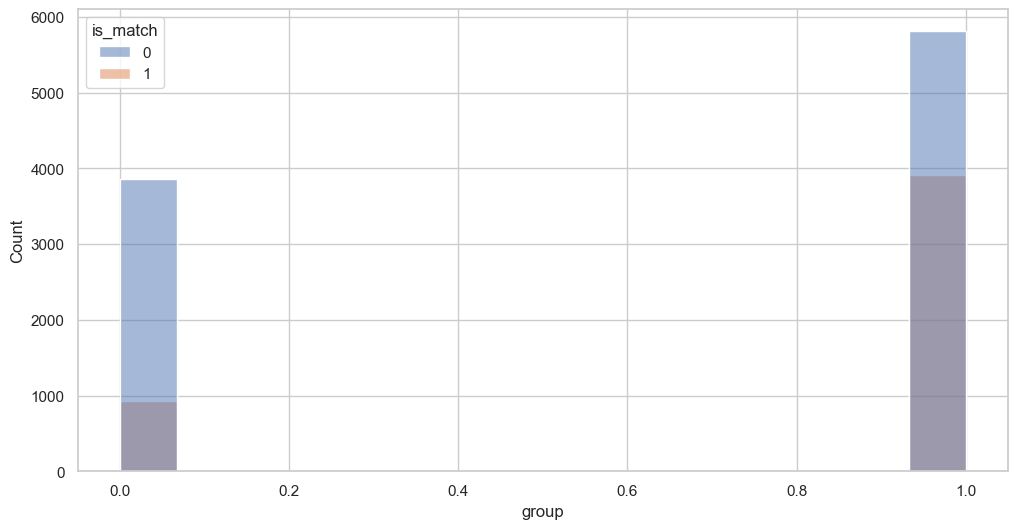

In [9]:
sns.histplot(df, x = 'group', hue='is_match') # визуализируем количество мэтчей и не мэтчей,
                                              # в зависимости от группы

Есть две категориальные переменные → будем использовать Хи-квадрат

- $H_0$: распределения в двух группах АБ-тестирования одинаковые. 
- $H_1$: распределения в двух группах АБ-тестирования различаются.

In [10]:
from scipy.stats import chi2_contingency, chi2 

In [11]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.is_match, df.group))

In [12]:
stat, p

(618.6889141576197, 1.441829916366341e-136)

In [13]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Нулевая гипотеза **отклоняется**, поскольку **p-value < 0. 05**.  
Значит, распределения в двух группах АБ-тестирования **различаются**.  
Новый алгоритм **стоит** включать на всех пользователей.